In [1]:
# SVM,OLS, LDA, QDA, KNN, RF, NN
#
# Balanced Accuracy, Sensitivity, Specificity, F1 Score

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Helper Methods

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Reading in Data

In [4]:
df = pd.read_csv('../ready4Learning2.csv', index_col = 0)
df.drop(df.tail(1).index,inplace=True)
df['Age@Scan'] = df['Age@Scan'].astype('float64')

print(df.ConsensusDiagnosis.value_counts())

print("\nDataType")
print(df['Age@Scan'].dtypes)

0    482
1    261
Name: ConsensusDiagnosis, dtype: int64

DataType
float64


### Downsampling

In [5]:
from sklearn.utils import resample

df_majority = df[df.ConsensusDiagnosis==0]
df_minority = df[df.ConsensusDiagnosis==1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=261,
                                   random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

print(df_downsampled.ConsensusDiagnosis.value_counts())

target = df_downsampled.ConsensusDiagnosis
features = df_downsampled.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate'], axis = 1)

1    261
0    261
Name: ConsensusDiagnosis, dtype: int64


In [6]:
features.head()

Age@Scan  Intracranial_Volume  LEC_Volume  LEC_Thickness  REC_Volume  \
658      46.2         1.588766e+06  360.791015       1.850467  246.533203   
644      51.9         1.301487e+06  233.789062       1.673710  158.642578   
7        57.6         1.580473e+06  707.739257       1.995442  696.752929   
590      36.1         1.574464e+06  336.181640       2.147858  356.176757   
628      52.0         1.519193e+06  442.089843       2.383512  365.625000   

     REC_Thickness      0      1      2      3  ...  270  271  272   273  274  \
658       1.709609   8192   6513   7731   7856  ...   18  122   85  1762  366   
644       1.395500  13372  10138  12739  12873  ...   34  178  292  2674  588   
7         1.744143  10778   7487   9763   8120  ...   23  292  166  2129  375   
590       2.246946   9166   6838   9138   8002  ...   20   88   48  2265  456   
628       2.282794  11240   9458  10757   9748  ...   22  182  197  2154  466   

     275  DAT  MCI  NCF  NCO  
658  500  0.0  0.0  1.0  0.0  
644  697  0.0  0.0  1.0  0.0  
7    493  0.0  0.0  1.0  0.0  
590  528  0.0  0.0  1.0  0.0  
628  480  0.0  0.0  1.0  0.0  

[5 rows x 286 columns]

In [7]:
#corrPlot(df_downsampled.loc[:, 'Age@Scan':'REC_Thickness'])
#savefig('../images/fig1.png')

###  Standardizing Data

In [8]:
from sklearn.preprocessing import StandardScaler

features = StandardScaler().fit_transform(features)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.33, random_state = 0)

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

penalties = ['l1', 'l2']
tols = [1e-2, 1e-3, 1e-4]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 'intercept_scaling': intercepts}

gs_logit = GridSearchCV(logit, params_logit, cv=10)

gs_logit.fit(features_train, target_train)


/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10], 'penalty': ['l1', 'l2'], 'tol': [0.01, 0.001, 0.0001], 'fit_intercept': [True, False], 'class_weight': [None, 'balanced'], 'intercept_scaling': [0.0001, 0.001, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.6364942528735633
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        29
           1       0.61      0.58      0.60        24

   micro avg       0.64      0.64      0.64        53
   macro avg       0.64      0.64      0.64        53
weighted avg       0.64      0.64      0.64        53



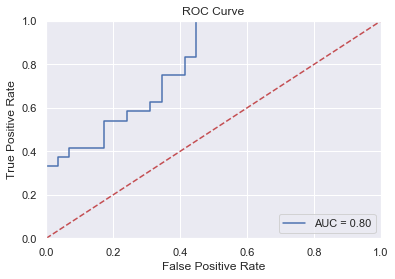

In [11]:
predictions = gs_logit.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_logit, 'test')

Balanced_Accuracy: 0.6966666666666667
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        80
           1       0.68      0.69      0.69        75

   micro avg       0.70      0.70      0.70       155
   macro avg       0.70      0.70      0.70       155
weighted avg       0.70      0.70      0.70       155



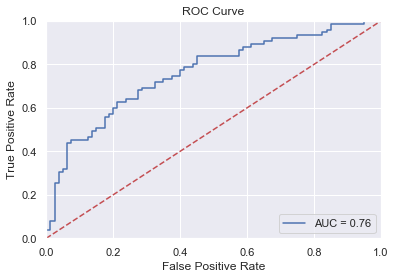

In [12]:
predictions = gs_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_logit, 'val')

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

solvers = ['lsqr']
shrinkages = [None, 'auto']
tols = [1e-3, 1e-4, 1e-5]
components = [0,1]

params_lda = {'solver': solvers,'shrinkage': shrinkages, 'tol': tols, 'n_components':components}

gs_lda = GridSearchCV(lda, params_lda, cv=10)


gs_lda.fit(features_train, target_train)
predictions = gs_lda.predict(features_test)

In [ ]:
getReport(predictions, 'test')
plotROC(gs_lda, 'test')

In [ ]:
predictions = gs_lda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

neighbors = [1,2,3,4,5]
weights = ['uniform', 'distance']
algo = ['ball_tree', 'kd_tree', 'brute']

params_knn = {'n_neighbors': neighbors, 'weights': weights, 'algorithm': algo}
gs_knn = GridSearchCV(knn, params_knn, cv=10)

gs_knn.fit(features_train, target_train)
predictions = gs_knn.predict(features_test)

In [ ]:
getReport(predictions, 'test')
plotROC(gs_knn, 'test')

In [ ]:
predictions = gs_knn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30]

params_rf = {'n_estimators': num_trees }


gs_rf = GridSearchCV(rf, params_rf, cv=10)


gs_rf.fit(features_train, target_train)
predictions = gs_rf.predict(features_test)

In [ ]:
getReport(predictions, 'test')
plotROC(gs_rf, 'test')

In [ ]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')

### NN

In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(activation='logistic')

nn.fit(features_train, target_train)
predictions = nn.predict(features_test)

In [ ]:
getReport(predictions, 'test')
plotROC(nn, 'test')

In [ ]:
predictions = nn.predict(features_val)
getReport(predictions, 'val')
plotROC(nn, 'val')

### SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


svm = SVC(kernel = 'linear', probability=True)

costs = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gammas = [0.005,.015, 0.01,0.02,0.03,0.04,0.05]
params_svm = {'C': costs, 'gamma' : gammas}

gs_svm = GridSearchCV(svm, params_svm, cv=10)

gs_svm.fit(features_train, target_train)
predictions = gs_svm.predict(features_test)

In [ ]:
getReport(predictions, 'test')
plotROC(gs_svm, 'test')

In [ ]:
predictions = gs_svm.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_svm, 'val')

### QDA REMOVE COLLINEAR VARIABLES

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

tols = [1e-3, 1e-4, 1e-5]
params_qda = {'tol': tols}

gs_qda = GridSearchCV(qda, params_qda, cv=10)

gs_qda.fit(features_train, target_train)
predictions = gs_qda.predict(features_test)

In [ ]:
getReport(predictions)
plotROC(gs_qda)